# Image Segmentation and Edge Detection
*convolution kernels*, *image segmentation*, *clustering*, *edge detection*

**Problem**

Given an image, we want to do segmentation and edge detection.

**Methods**

We will demonstrate the following methods:

\begin{enumerate}
\item Using k-means for image segmentation
\item Using Otzu's method for foreground and background removal for grayscale image
\item Using Sobel operator for edge detection
\end{enumerate}

In [1]:
import numpy as np
import pandas as pd
from math import floor
import scipy.ndimage as ndi
from PIL import Image, ImageOps
from sklearn.cluster import k_means
import math
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 4)

In [36]:
# kernels 
kernels = {
    'Gaussian': 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]),
    'Laplacian': np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]),
    'Denoise': 1/9 * np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
    'Sharpen': np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]),
    'Sobel': np.array([[1, 2, 1],[ 0, 0, 0],[-1, -2, -1]] )/8,
    'Prewitt': np.array([[-1, 0, 1],[ -1, 0, 1],[-1, 0, 1]] )
}

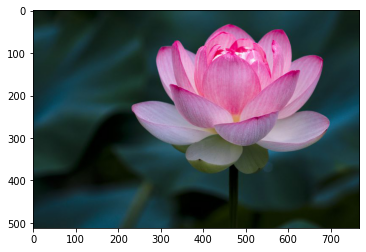

In [59]:
# read and show the image 
image = plt.imread('HW images/lotus-flower-1.jpg')    
plt.imshow(image)
plt.show()

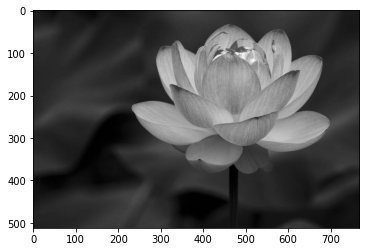

In [60]:
# transform to gray scale 
rgb_weights = [0.2989, 0.5870, 0.1140]
image_gray = np.dot(image, rgb_weights)
plt.imshow(image_gray, cmap='gray', vmin=0, vmax=255)
plt.show()

### Foreground and Background Removal 

For grayscale images, we can segment them into foreground and background. The idea of foreground and backgroudn removal is to find a threshold $t$ that separates the two. Otzu's method can be used to automatically determine the threhsold given an image histogram. The model is formulated as finding the $t$ that maximizes the intra-class variance (or minimizes inter-class variance):
$$
\sigma^2_w(t) = w_1(t) \sigma^2_1(t) + w_2(t) \sigma^2_2(t),
$$

where weight $w_i(t)$ are the probabilities of the two classes separated by threhsold $t$, and $\sigma^2_i(t)$ are the variances of these classes. 

The inter class variance can be written as:
$$
\sigma^2_b(t) = \sigma^2 - \sigma_w^2(t) = w_1(t)(\mu_1 - \mu_T)^2 + w_2(t)(\mu_2 - \mu_T)^2 = w_1(t)w_2(t)(\mu_1(t) - \mu_2(t))^2
$$

Alternatively, we can define the inter-class discrete matrix as 
$$
S_b = \sum^1_{k=1} w_k [(\mu_k - \mu_T)(\mu_k - \mu_T)^T],
$$

and solve the problem by maximizing the trace of $S_b$:
$$
tr(S_b) = \frac{(\mu_{Ti}w_1 - \mu_i)^2 + (\mu_{Tj}w_1 - \mu_j)^2}{w_1(1-w_1)}
$$


Threshold: 93


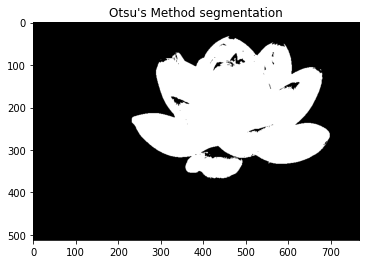

In [417]:
# Otzu's method 

# Step 1: Calculate histogram 
I = image_gray.ravel()
num_bins = 256
bins = np.arange(0, num_bins+1, 1, dtype=int)
hist, _ = np.histogram(I, bins=bins, density=True)

# Step 2: Calculate group mean
omega = np.cumsum(hist)                         # w1
mu = np.cumsum(hist * np.arange(1, num_bins+1)) # mu1
mu_t = mu[-1]

# Step 3: find the maximum value of the objective function 
sigma_b_squared = (mu_t * omega - mu)**2 / (omega * (1 - omega))
maxval = sigma_b_squared.max()
idx = np.argmax(sigma_b_squared)

# Step 4: Thresholding and get final image
level = (idx - 1) / (num_bins - 1)
print("Threshold:", int(level*num_bins))
image_bw = image_gray > level*num_bins
plt.title("Otsu's Method segmentation")
plt.imshow(image_bw, cmap='gray')
plt.show()

## Image Segmentation using K-means 

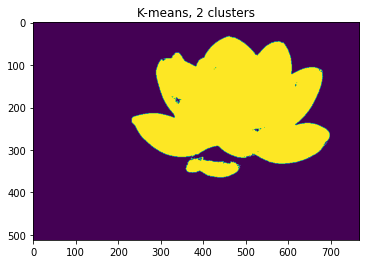

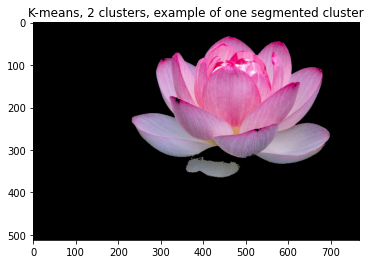

In [93]:
# vectorize into N by 3 matrix 
X = image.reshape(-1, image.shape[2]).astype(float) 

# segmentation with K-means 
Ks = [2]#, 4, 6, 8, 10]
for k in Ks:
    centers, L,_ = k_means(X, k)
    t = L.reshape(*image.shape[:2])
    plt.figure()
    plt.imshow(t)
    plt.title(f"K-means, {k} clusters")
    plt.show()
    for c in range(k):
        plt.imshow(np.multiply((t==c)[:,:,None], image))
    plt.title(f'K-means, {k} clusters, example of one segmented cluster')
    plt.show()


## Edge detection using Sobel

The sobel operators are pre-defined kernel matrices, which can be used as convolution filters for edge detection. We first apply convolution of the sobel filter in the x direction, then in the y direction. The final result is the squared power of the two outputs binarized by a threshold. When threshold is small, a lot of small contours and noise are also considered as edges. For bigger thresholds, the edges are cleaner.

In [454]:
# apply sobel filters 
fx = ndi.convolve(image_gray, kernels['Sobel'].T, mode='nearest')
fy = ndi.convolve(image_gray, kernels['Sobel'], mode='nearest')
image_edge = np.power(fx, 2) + np.power(fy, 2)

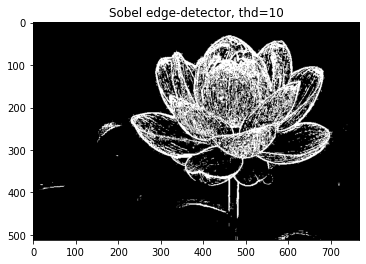

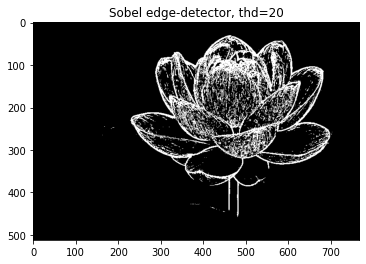

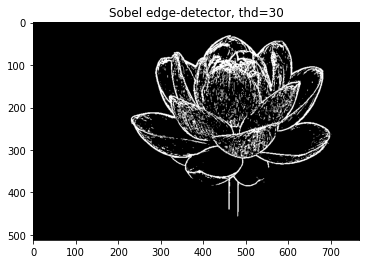

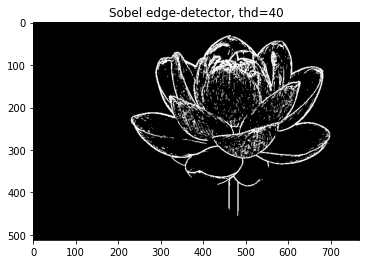

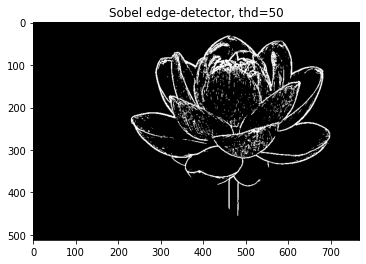

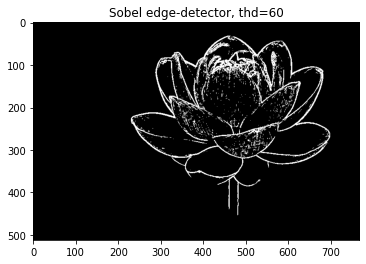

In [456]:
# visualize results for different thresholds 
thds = [10,20,30,40,50,60]
for thd in thds:
    t = (image_edge > thd)
    plt.imshow(t, cmap="gray")
    plt.title('Sobel edge-detector, thd=' + str(thd))
    plt.show() 

## Edge detection using Prewitt

We apply Prewitt's operator for the color image for edge detection. We apply the edge detection to each of R, G, B layers separately, apply the threshold filter to each layer, then merge back to one layer. We can observe that the result is much noisier than Sobel applied on grayscale. This is because edge detection on each color layer can be noisy, and intensity changes of a single color may not represent the true edge.

In [48]:
# apply Prewitt to each color layer 
image_edge = np.zeros(image.shape)
for i in range(3):
    fx = ndi.convolve(image[:,:,i], kernels['Prewitt'].T, mode='nearest')
    fy = ndi.convolve(image[:,:,i], kernels['Prewitt'], mode='nearest')
    image_edge[:,:,i] = (np.power(fx, 2) + np.power(fy, 2)).astype('uint8')

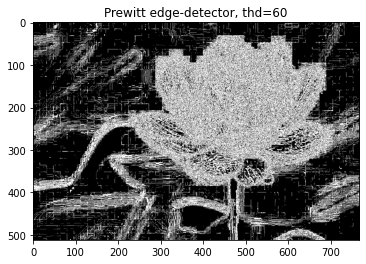

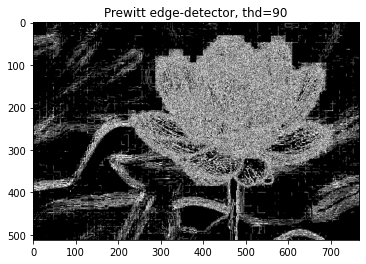

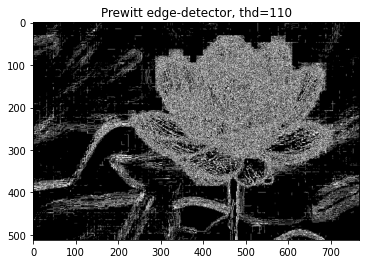

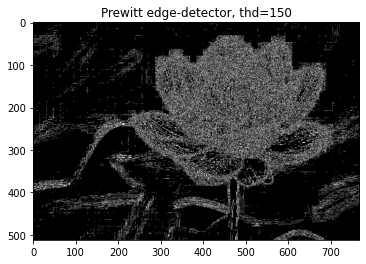

In [50]:
# visualize results for different thresholds 
thds = [60,90,110,150]
for thd in thds:
    t = (image_edge > thd)
    t = t.mean(2)
    plt.imshow(t, cmap="gray")
    plt.title('Prewitt edge-detector, thd=' + str(thd))
    plt.show() 